## Basic Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from fastai.vision import *
from pathlib import Path
from utils import *
from tqdm import tqdm, tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import cv2

matplotlib.style.use('fivethirtyeight')

In [2]:
%%capture
learn = load_learner('/Users/rahulsomani/01_github_projects/shot-type-classifier/models/', file='shot-type-classifier.pkl');

In [3]:
path = Path('~/Desktop/movies/the-social-network-splits/')

## Reading in Video with `cv2` and Predicting Shot Type 

Somehow, when reading in videos with `cv2`, the last 5 frames always get skipped.

### OpenCV Properties Key 

0. `CV_CAP_PROP_POS_MSEC` Current position of the video file in milliseconds.
1. `CV_CAP_PROP_POS_FRAMES` 0-based index of the frame to be decoded/captured next.
2. `CV_CAP_PROP_POS_AVI_RATIO` Relative position of the video file
3. `CV_CAP_PROP_FRAME_WIDTH` Width of the frames in the video stream.
4. `CV_CAP_PROP_FRAME_HEIGHT` Height of the frames in the video stream.
5. `CV_CAP_PROP_FPS` Frame rate.
6. `CV_CAP_PROP_FOURCC` 4-character code of codec.
7. `CV_CAP_PROP_FRAME_COUNT` Number of frames in the video file.
8. `CV_CAP_PROP_FORMAT` Format of the Mat objects returned by retrieve() .
9. `CV_CAP_PROP_MODE` Backend-specific value indicating the current capture mode.
10. `CV_CAP_PROP_BRIGHTNESS` Brightness of the image (only for cameras).
11. `CV_CAP_PROP_CONTRAST` Contrast of the image (only for cameras).
12. `CV_CAP_PROP_SATURATION` Saturation of the image (only for cameras).
13. `CV_CAP_PROP_HUE` Hue of the image (only for cameras).
14. `CV_CAP_PROP_GAIN` Gain of the image (only for cameras).
15. `CV_CAP_PROP_EXPOSURE` Exposure (only for cameras).
16. `CV_CAP_PROP_CONVERT_RGB` Boolean flags indicating whether images should be converted to RGB.
17. `CV_CAP_PROP_WHITE_BALANCE` Currently unsupported
18. `CV_CAP_PROP_RECTIFICATION` Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)

### Frame Grabbing Function

In [4]:
from fastai.vision import *

get_fps     = lambda fname: cv2.VideoCapture(fname).get(cv2.CAP_PROP_FPS)
get_nframes = lambda fname: int(cv2.VideoCapture(fname).get(cv2.CAP_PROP_FRAME_COUNT))
to_tensor   = lambda x: pil2tensor(x, np.float32).div_(255)
to_img      = lambda x: Image(pil2tensor(x, np.float32).div_(255))

def grab_frames(fname, frames, ret_type='fastai'):
    '''
    Doc goes here hehe...
    '''
    # essential checks
    assert ret_type in ['np', 'fastai', 'tensor'], 'Choose either \'np\',  \'fastai\' or \'tensor\' as your return type'
    assert isinstance(frames, (tuple, list, int)), '`frames` must be either a tuple, list, or int'
    
    # prep video
    fps, num_frames = get_fps(fname), get_nframes(fname)

    # get frame indices (targets) for video
    if   isinstance(frames, tuple) : target_frames = np.arange(*frames)
    elif isinstance(frames, list)  : target_frames = frames
    elif isinstance(frames, int)   : target_frames = [frames]

    # grab the targeted frames
    grabbed=[]
    for i in target_frames:
        cap = cv2.VideoCapture(fname)
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret==True: grabbed.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # return np.array
        else: break
    cap.release()
    
    # optionally return fastai.vision.image.Image for convenience
    # this allows you to run `learn.predict()` and view the image directly. 
    if ret_type == 'fastai': grabbed = [to_img(x) for x in grabbed]
    if ret_type == 'tensor': grabbed = torch.stack([to_tensor(x) for x in grabbed])
    
    return grabbed, target_frames, (fname, fps, num_frames)


### Predict Function

In [5]:
get_shot_idx  = lambda path: int(
    str(path)            ## /home/...../shot#0002.mp4
        .rsplit('/')[-1] ## shot#0002.mp4
        .split('.')[0]   ## shot#0002
        .split('#')[-1]  ## 0002 --> 2
)

# f = str(path/'shot#0002.mp4')
# get_shot_idx(f)
# get_shot_idx(os.listdir(path)[0])

def get_key_pred(df):
    i = df.groupby(['shot_no'])['prediction'].transform(max) == df['prediction']
    return df[i]

def predict(frame, frame_idx, fname, fps, num_frames):
    classes = ['Close-Up', 'Extreme Close-Up', 'Extreme Wide', 'Long', 'Medium', 'Medium Close-Up']
    shot_idx = get_shot_idx(fname)

    # get preds
    pred, _, pred_ps = learn.predict(frame)

    # form data-frame
    df = pd.DataFrame(list(zip(classes, pred_ps.numpy())), columns=['shot_type', 'prediction'])

    # replace shot-types with acronyms
    df['shot_type'].replace({    'Extreme Wide': 'EWS',
                                         'Long': 'LS',
                                       'Medium': 'MS',
                              'Medium Close-Up': 'MCU',
                                     'Close-Up': 'CU',
                             'Extreme Close-Up': 'ECU'}, inplace=True)
    # set sorting order for shot-types and sort
    df['shot_type'] = pd.Categorical(df['shot_type'], ['EWS', 'LS', 'MS', 'MCU', 'CU', 'ECU'])
    df = df.sort_values('shot_type').reset_index(drop=True)

    # add more info
    df['prediction'] *= 100
    df['frame_no']    = frame_idx+1
    df['shot_no']     = shot_idx
    df['shot_length'] = num_frames / get_fps(fname)
    
    #print(f'Shot #{shot_idx:04d}, Frame #{frame_idx+1:04d}: {pred}')
    return df, get_key_pred(df)

### Getting Predictions for All Files In a Directory

In [4]:
movie_path = '/home/home/rahul/Desktop//Desktop/movies/the-social-network.mkv'
movie_name = movie_path.split('/')[-1].split('.')[0]
movie_name

'the-social-network'

In [54]:
preds_key = pd.read_csv(path/'preds-key.csv') if Path.exists(path/'preds-key.csv') else []
preds_all = pd.read_csv(path/'preds-all.csv') if Path.exists(path/'preds-all.csv') else []

os.chdir(path)
fnames = [f for f in sorted(os.listdir(path)) if f.endswith('.mp4')]

for fname in tqdm_notebook(fnames[2200:]):
    # prep video and its properties
    frame_stride  = 6
    target_frames = (0, get_nframes(fname), frame_stride)  
    frames, target_frames, info  = grab_frames(fname, target_frames)

    # get predictions with multiple levels of info
    for i,frame in zip(target_frames,frames):
        preds_i, pred_i = predict(frame, i, *info)
        
        # why doesn't this work as a function?
        if isinstance(preds_key, list): preds_key.append(pred_i)
        else: preds_key = pd.concat([preds_key, pred_i])
            
        if isinstance(preds_all, list): preds_all.append(preds_i)
        else: preds_all = pd.concat([preds_all, preds_i])
    
    if isinstance(preds_key, list): preds_key = pd.concat(preds_key, ignore_index=True)
    if isinstance(preds_all, list): preds_all = pd.concat(preds_all, ignore_index=True)

    preds_key.drop_duplicates().to_csv(path/'preds-key.csv', index=False)
    preds_all.drop_duplicates().to_csv(path/'preds-all.csv', index=False)


In [56]:
type(learn)

fastai.basic_train.Learner

In [57]:
order = lambda df: df.sort_values(['shot_no', 'frame_no'])
order(preds_key)

,shot_type,prediction,frame_no,shot_no,shot_length
0,EWS,92.825830,1,1,30.739042
1,EWS,93.818545,7,1,30.739042
2,EWS,95.311713,13,1,30.739042
3,EWS,92.505276,19,1,30.739042
4,EWS,90.770406,25,1,30.739042
...,...,...,...,...,...
4,CU,99.936980,205,2296,9.634625
4,CU,99.969363,211,2296,9.634625
4,CU,99.965477,217,2296,9.634625
4,CU,99.925834,223,2296,9.634625


## Analysing Predictions

### Using `R`

This code is much cleaner, more understandable and faster than the same with `python`

In [101]:
%load_ext rpy2.ipython

In [22]:
preds_key = pd.read_csv('~/Desktop/preds-key.csv')

In [138]:
%%R -i preds_key

library(dplyr)
library(readr)
library(purrr)

df <- read_csv('preds-key.csv')

shot_list_aggr <-
    df %>%
    group_by  (shot_no, shot_type) %>%
    summarise (prediction_mean   = weighted.mean(prediction),
               num_frames        = n(),
               shot_length       = unique(shot_length)) %>%
    mutate(rel_length = shot_length * num_frames / sum(num_frames)) 

clean         <- function(x) x %>% unlist %>% unique
inspect_shots <- function(shot_list_aggr, conf_type, pred_threshold) {
    shot_list_aggr %>%
    split(., .$shot_no) %>%
    map(., function(df) {
        unconf <- df %>% filter(prediction_mean > pred_threshold)
        if(conf_type == 'ambiguous') {
            if(unique(unconf$shot_type) %>% length > 1) unique(df$shot_no)
        }
        else if(conf_type == 'confident') {
            if(unique(unconf$shot_type) %>% length == 1) unique(df$shot_no)
        }
        else if(conf_type == 'hopeless') {
            if(unique(unconf$shot_type) %>% length == 0) unique(df$shot_no)
        }
        else NULL
    }) %>% clean
}

## shots with MULTIPLE confident predictions
## these probably involve camera or character movement
shots_conf_multiple_preds <- inspect_shots(shot_list_aggr, 'ambiguous', 70)

## shots with ONE confident prediction (what we're SURE AF of)
shots_conf_preds          <- inspect_shots(shot_list_aggr, 'confident', 70)

## shots where there are ZERO confident predictions
shots_noconf_preds        <- inspect_shots(shot_list_aggr, 'hopeless', 70)

## sanity check -- sum of the no. of above shots should be equal
## to the total number of shots
map(list(shots_conf_multiple_preds,
         shots_conf_preds,
         shots_noconf_preds), function(x) length(x)) %>%
    clean %>% sum == (unique(df$shot_no) %>% length)


## df <- shot_list_aggr
## df %>% filter(shot_no %in% shots_conf_multiple_preds)
## df %>% filter(shot_no %in% shots_conf_preds)
## df %>% filter(shot_no %in% shots_noconf_preds)


write_csv(shot_list_aggr, 'shot-list-aggr.csv')

## write.csv(shots_conf_multiple_preds, 'shots-conf-multiple-preds.csv')
## write.csv(shots_conf_preds, 'shots-conf-preds.csv')
## write.csv(shots_noconf_preds, 'shots-conf-multiple-preds.csv')

R[write to console]: Parsed with column specification:
cols(
  shot_type = col_character(),
  prediction = col_double(),
  frame_no = col_double(),
  shot_no = col_double(),
  shot_length = col_double()
)



### Using `Python`

In [5]:
preds_key = pd.read_csv('~/Desktop/preds-key.csv')

In [6]:
%%capture
shot_list_aggr_ = []
for j, df in preds_key.groupby(['shot_no', 'shot_type']):
    df['num_frames'] = df['shot_no'].count()
    df = df.agg({
        'shot_no'    : 'unique',
        'shot_type'  : 'unique',
        'prediction' : 'mean',
        'num_frames' : 'count',
        'shot_length': 'unique'
    })
    shot_list_aggr_.append(df)
    
shot_list_aggr=[]
for i, df in pd.concat(shot_list_aggr_).groupby(['shot_no']):
    s = df['num_frames'].sum()
    df['rel_length'] = df.apply(lambda x: x['shot_length'] * x['num_frames'] / s, axis=1)
    shot_list_aggr.append(df)

In [7]:
shot_list_aggr = pd.concat(shot_list_aggr)
shot_list_aggr

,shot_no,shot_type,prediction,num_frames,shot_length,rel_length
0,1,CU,37.512729,2,30.739042,0.499822
0,1,ECU,64.707236,5,30.739042,1.249555
0,1,EWS,88.789386,19,30.739042,4.748307
0,1,LS,88.536321,55,30.739042,13.745100
0,1,MS,77.297405,42,30.739042,10.496258
0,2,MCU,96.330988,9,2.085417,2.085417
0,3,MCU,96.705652,10,2.335667,2.335667
0,4,MCU,96.102232,6,1.418083,1.418083
0,5,MCU,98.458011,9,2.210542,2.210542
0,6,MCU,93.590657,4,0.792458,0.792458


### Using `rpy2`

In [2]:
preds_key = pd.read_csv('~/Desktop/preds-key.csv')

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.lib.dplyr import (DataFrame, mutate, group_by, summarise)
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/rpy2/robjects/lib/dplyr.py:24: UserWarning: This was designed againt dplyr version 0.7.5 but you have 0.8.3
  warnings.warn('This was designed againt dplyr version %s but you have %s' % (TARGET_VERSION, dplyr.__version__))


In [4]:
with localconverter(ro.default_converter + pandas2ri.converter):
  df = ro.conversion.py2ro(preds_key)

In [5]:
# sla --> shot-list-aggregated

sla = group_by  (df, 'shot_no', 'shot_type')
sla = summarise (sla,
                prediction_mean = 'weighted.mean(prediction)',
                num_frames      = 'n()', 
                shot_length     = 'unique(shot_length)')
sla = mutate(sla, rel_length = 'shot_length * num_frames / sum(num_frames)')
sla

shot_no,shot_type,prediction_mean,num_frames,shot_length,rel_length
1,'CU',37.512729,2,30.739042,0.499822
1,'ECU',64.707236,5,30.739042,1.249555
1,'EWS',88.789386,19,30.739042,4.748307
1,'LS',88.536321,55,30.739042,13.745100
...,...,...,...,...,...
"2,293",'MCU',92.036991,76,20.478792,18.980343
"2,294",'ECU',77.262370,10,2.293958,2.293958
"2,295",'ECU',90.625331,10,2.419083,2.419083
"2,296",'CU',99.655705,39,9.634625,9.634625


In [6]:
sla

shot_no,shot_type,prediction_mean,num_frames,shot_length,rel_length
1,'CU',37.512729,2,30.739042,0.499822
1,'ECU',64.707236,5,30.739042,1.249555
1,'EWS',88.789386,19,30.739042,4.748307
1,'LS',88.536321,55,30.739042,13.745100
...,...,...,...,...,...
"2,293",'MCU',92.036991,76,20.478792,18.980343
"2,294",'ECU',77.262370,10,2.293958,2.293958
"2,295",'ECU',90.625331,10,2.419083,2.419083
"2,296",'CU',99.655705,39,9.634625,9.634625


## Interactive Visualisation

In [4]:
os.chdir('/Users/rahulsomani/Desktop/')

In [5]:
shot_list_aggr = pd.read_csv('shot-list-aggr.csv')
shot_list_aggr.head(10)

,shot_no,shot_type,prediction_mean,num_frames,shot_length,rel_length
0,1,CU,37.512729,2,30.739042,0.499822
1,1,ECU,64.707236,5,30.739042,1.249555
2,1,EWS,88.789386,19,30.739042,4.748307
3,1,LS,88.536321,55,30.739042,13.745100
4,1,MS,77.297405,42,30.739042,10.496258
5,2,MCU,96.330988,9,2.085417,2.085417
6,3,MCU,96.705652,10,2.335667,2.335667
7,4,MCU,96.102232,6,1.418083,1.418083
8,5,MCU,98.458011,9,2.210542,2.210542
9,6,MCU,93.590657,4,0.792458,0.792458


### Matplotlib -- Why we won't use it

/home/rahul/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


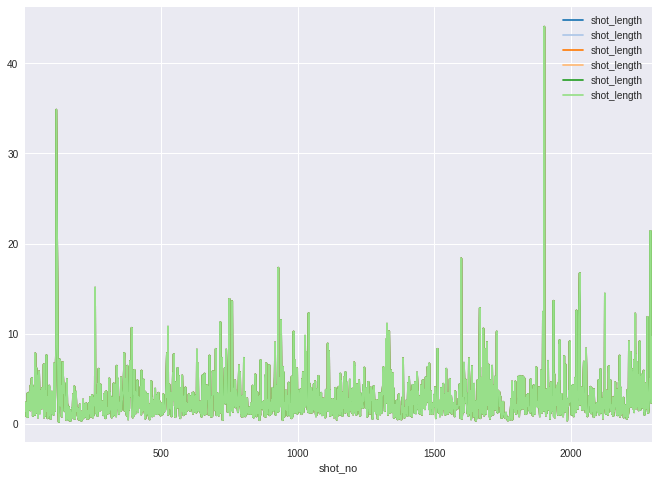

In [33]:
# https://nipunbatra.github.io/blog/2017/50-ggplot-python-1.html
colors = [(31, 119, 180),  (174, 199, 232), (255, 127, 14),  (255, 187, 120),  
          (44, 160, 44),   (152, 223, 138), (214, 39, 40),   (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75),   (196, 156, 148),  
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
          (188, 189, 34),  (219, 219, 141), (23, 190, 207),  (158, 218, 229)]

colors = [(r/255., g/255., b/255.) for r,g,b in colors]

matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
for i, (name, group) in enumerate(shot_list.groupby('shot_type')):
    shot_list.plot(x='shot_no',y='shot_length', figsize=(10,8), ax=ax, colors=colors[i])

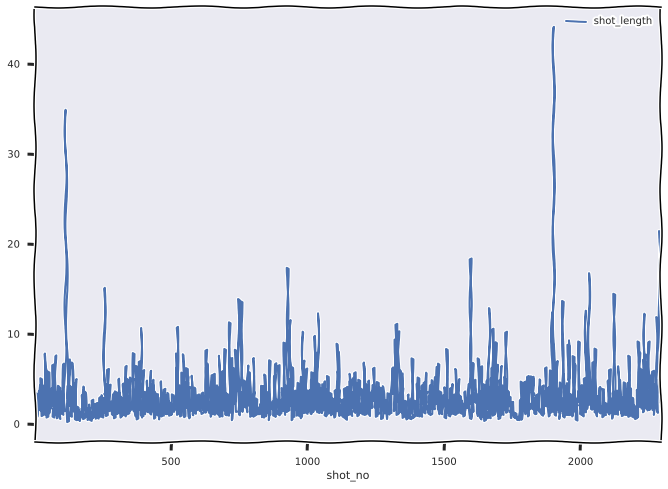

In [16]:
with plt.xkcd():
    shot_list.plot(x='shot_no',y='shot_length', figsize=(10,8))

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


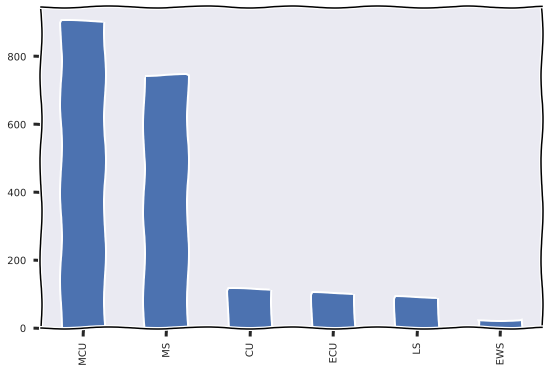

In [92]:
with plt.xkcd():
    shot_list['shot_type'].value_counts().plot(kind='bar')

### Altair

<br>

An excellent data-viz library which is very intuitive, functional, and follows a good grammar of graphics. <br>
Here's a video tutorial: https://www.youtube.com/watch?v=ms29ZPUKxbU

In [6]:
shot_list_aggr[shot_list_aggr['shot_no'] == 115]

,shot_no,shot_type,prediction_mean,num_frames,shot_length,rel_length
122,115,EWS,92.86826,135,34.868167,33.622875
123,115,LS,57.82764,5,34.868167,1.245292


In [10]:
import vega

In [17]:
import altair as alt

#alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()
#alt.data_transformers.enable('json')

selector_color = alt.selection_multi(encodings=['color'], bind='legend')
brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(shot_list_aggr).mark_bar(binSpacing=0.01).encode(
    x = alt.X('shot_no', scale=alt.Scale(domain=brush)),
    y = 'rel_length',
    color = alt.condition(selector_color, 'shot_type', alt.value('lightgray')),
    tooltip = 'prediction_mean'
)

upper = base.properties(
    width = 1000,
    selection = selector_color
)#.interactive()

view = upper.properties(
    height=100,
).add_selection(brush)

upper & view

DataTransformerRegistry.enable('default')

alt.VConcatChart(...)

In [24]:
shots_all.head(20)

,shot_type,prediction,frame_no,shot_no,shot_length
0,EWS,92.825830,1,1,30.739042
1,EWS,93.818545,7,1,30.739042
2,EWS,95.311713,13,1,30.739042
3,EWS,92.505276,19,1,30.739042
4,EWS,90.770406,25,1,30.739042
5,EWS,86.207801,31,1,30.739042
6,EWS,95.516926,37,1,30.739042
7,ECU,63.425332,43,1,30.739042
8,ECU,64.240581,49,1,30.739042
9,ECU,69.415599,55,1,30.739042


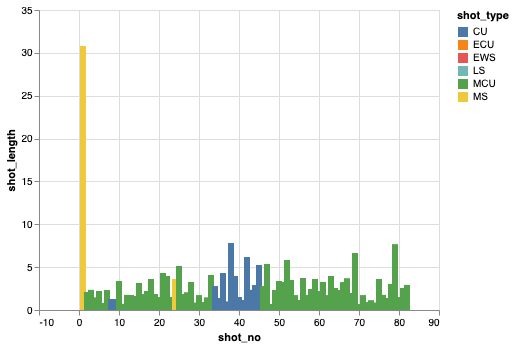

In [26]:
alt.Chart(shots_all[:1000]).mark_bar().encode(
    x = 'shot_no',
    y = 'shot_length',
    color = 'shot_type'
).interactive()

In [133]:
from vega_datasets import data

In [134]:
data.barley()

,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids
...,...,...,...,...
115,58.16667,Wisconsin No. 38,1932,Waseca
116,47.16667,Wisconsin No. 38,1932,Morris
117,35.90000,Wisconsin No. 38,1932,Crookston
118,20.66667,Wisconsin No. 38,1932,Grand Rapids
